This notebook helps you implement a Denoising Diffusion Probabilistic Model (DDPM) and Classifier-free diffusion guidance.  
As the main part, you can use the [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf) and [classifier-free guidance](https://arxiv.org/abs/2207.12598) as references.

In this notebook you need to complete the notebook and run all the cells.

# Introduction

Denoising Diffusion Probabilistic Models (DDPMs) are deep generative models that have recently gained significant attention due to their remarkable performance. Cutting-edge models such as OpenAI’s DALL-E 2 and Google’s Imagen generators are built upon DDPMs.

The core concept is straightforward: given an image dataset, we progressively add small amounts of noise in multiple steps. With each step, the image becomes increasingly unclear until it turns into pure noise—this is known as the "forward process." Then, we train a machine learning model to reverse these steps, a process referred to as the "backward process." If the backward process is successfully learned, the model can generate images from random noise.

In the forward process, each step involves adding noise to an image (denoted as $x_t$) by sampling from a multivariate Gaussian distribution. The mean of this distribution is a scaled-down version of the previous image ($x_{t-1}$), while the covariance matrix remains diagonal and fixed. Essentially, each pixel in the image is independently perturbed by adding a normally distributed value.

![image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png)

For the backward process, the model is expected to follow a Gaussian distribution, meaning it must predict the mean and standard deviation of the distribution given the noisy image and time step. In the original DDPM paper, the covariance matrix is fixed, so the primary objective is to predict the mean of the Gaussian distribution based on the noisy image and the current time step.

![image](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_forward_diffusion_process-1.png)

## 1. Unconditional DDPM (60 points)

We will explore the details of both the forward (diffusion) and backward (denoising) processes in the relevant sections.

In this notebook, our goal is to implement a DDPM from scratch to generate random MNIST images from noise. Additionally, we aim to condition our DDPM on the MNIST label, enabling it to generate images corresponding to specific class.

## 1.1. Packages

In [29]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from pytorch_fid import fid_score
import tempfile

%matplotlib inline

from torch.utils.data import DataLoader, Dataset

In [7]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1.2. Dataset
As it was mentioned, for this notebook we use the MNIST dataset, and we aim to generate the similar images of this dataset by our DDPM. For loading the dataset, you can use torchvision. You should apply this transformations for loading images:

* convert them into a tensor
* and normalize values to a `mean` and `standard deviation` of 0.5.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Now, define an instance of MNIST dataset with the specified transformations and load it to a `dataloader`.

In [ ]:
batch_size = 128
dataset = datasets.MNIST(
    root='./data',   
    train=True,      
    download=True,   
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True
)

## 1.3. U-Net Architercture (32 points)

The U-Net architecture, a convolutional neural network framework, has become a highly effective solution for semantic segmentation tasks. Its distinctive U-shaped design enables it to efficiently capture both global and local features, allowing it to excel in various segmentation challenges.

U-Net is composed of two main components: a contracting path and an expansive path. The contracting path follows a standard convolutional network structure, involving repeated applications of two 3×3 convolutions (without padding), each followed by a rectified linear unit (ReLU) activation and a 2×2 max pooling operation with a stride of 2 for downsampling. With each downsampling step, the number of feature channels doubles.

The expansive path, on the other hand, consists of upsampling the feature map, followed by a 2×2 convolution ("up-convolution") that reduces the number of feature channels by half. This is then concatenated with the corresponding cropped feature map from the contracting path, followed by two 3×3 convolutions, each accompanied by a ReLU activation.

![unet architecture](https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg)

The figure above represents the original U-Net architecture introduced in 2015. However, for this notebook, we will work with a modified version that incorporates additional sub-modules. In the subsequent sections, we will define and implement the necessary components to build our final network.

### 1.3.1 time step embedding class
We define the `TimestepEmbedSequential` to support the time embedding as the extra input for the layers of model.

In [11]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb)
            else:
                x = layer(x)
        return x

### 1.3.2 Residual Block


As a fundamental sub-module, each ResNet block consists of two consecutive convolutional layers, with Group Normalization and SiLU activation applied **before** each convolution. This block serves as a building block for other sub-modules, such as Downsampling and Upsampling layers.

Additionally, a linear projection layer transforms the time embedding vector into a vector with the same number of channels as the output. This projected time embedding is then added to the input after the first convolutional layer. By removing the residual connection, this block can also function as a standard convolutional network.

It's important to note that if the number of input and output channels for the feature maps differ, directly adding the input to the output in a residual connection can cause inconsistencies. To address this, a 1×1 convolution can be applied to align the input channels with the output dimensions.

Optionally, a dropout layer can be included before the second convolution layer. By default, the dropout probability is set to zero, but it can be activated as needed in the final architecture.

In [ ]:
# Residual block
class Residual_block(TimestepBlock):
    """
    Residual block for U-Net architecture.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        time_channels (int): Size of the time embedding.
        dropout (float, optional): Dropout probability. Default is 0.
        num_groups (int): Number of groups to split the input into for normalization. Default is 32.
    """
    def __init__(self, in_channels, out_channels, time_channels, dropout, num_groups=32):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.time_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.act2 = nn.SiLU()
        self.dropout_layer = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x, t):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        h_skip = x
        
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv1(x)

        projected_time_emb = self.time_emb_proj(t)

        
        x = x + projected_time_emb.unsqueeze(-1).unsqueeze(-1)

        x = self.norm2(x)
        x = self.act2(x)
        x = self.dropout_layer(x)
        x = self.conv2(x)

        h_skip_processed = self.skip_connection(h_skip)

        return x + h_skip_processed

### 1.3.3 Attention Block
This sub-module consisting of :
 * a Group Normalization
 * Multi-head Attention (Implement from scratch)
 * a feed-forward layer
 * residual conntection

In [ ]:
class AttentionBlock(nn.Module):
    """
    Initializes the AttentionBlock module.

    Args:
        channels (int): Number of input channels.
        num_heads (int): Number of attention heads to use.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    def __init__(self, channels, num_groups = 32, num_heads=1):
        super().__init__()
        if channels % num_heads != 0:
            raise ValueError(f"channels ({channels}) must be divisible by num_heads ({num_heads})")

        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        self.norm = nn.GroupNorm(num_groups=num_groups, num_channels=channels)

        self.to_qkv = nn.Linear(channels, channels * 3)
        self.mha_output_proj = nn.Linear(channels, channels)

        ffn_hidden_dim = channels * 4
        self.ffn = nn.Sequential(
            nn.Linear(channels, ffn_hidden_dim),
            nn.SiLU(),
            nn.Linear(ffn_hidden_dim, channels)
        )
        
    def forward(self, x):
        """
          Forward pass of the AttentionBlock module.

          Args:
              x (torch.Tensor): Input tensor of shape (batch_size, seq_len, channels).

          Returns:
              torch.Tensor: Output tensor
        """
        B, C, H, W = x.shape
        residual = x

        norm_x = self.norm(x)

        S = H * W
        reshaped_x = norm_x.view(B, C, S).permute(0, 2, 1).contiguous()

        qkv = self.to_qkv(reshaped_x)

        q, k, v = torch.chunk(qkv, 3, dim=-1)

        q = q.view(B, S, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(B, S, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(B, S, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) * (self.head_dim ** -0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)

        attention_output_heads = torch.matmul(attention_probs, v)

        attention_output_concat = attention_output_heads.permute(0, 2, 1, 3).contiguous().view(B, S, C)
        mha_output = self.mha_output_proj(attention_output_concat)

        ffn_output = self.ffn(mha_output)

        transformed_output = ffn_output.permute(0, 2, 1).contiguous().view(B, C, H, W)

        output = residual + transformed_output

        return output

### 1.3.4 Down-sampling Block

This block should be used in the contractive path of the model. The downsampling module halves the width and height of the input and can be implemented using either a convolution layer with `stride=2` or an average pooling layer with `kernel_size=2`, which dependes on the boolean argument `use_conv`.

In [ ]:
class Downsample(nn.Module):
    """
    Downsampling block for U-Net architecture.

    Args:
        channels (int): Number of input channels.
        use_conv (bool): Flag indicating whether to use convolution or average pooling.
    """
    def __init__(self, channels, use_conv):
        super().__init__()
        if use_conv:
            self.op = nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                stride=2,
                padding=1
            )
        else:
            self.op = nn.AvgPool2d(
                kernel_size=2,
                stride=2
            )

    def forward(self, x):
      """
        Forward pass of the Downsample block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
      """
      return self.op(x)

### 1.3.5 Up-sampling Block

This module should be used in the expansive path of the U-Net model. The main purpose of this module is to doubles the width and height of image tensor. For implementation, ypu can use interpolation followed by an optional convolutional layer (determined by `use_conv` argument)

In [ ]:
class Upsample(nn.Module):
    """
    Upsampling block for U-Net architecture.

    Args:
        channels (int): Number of input channels.
        use_conv (bool): Flag indicating whether to add convolutional layer.
    """
    def __init__(self, channels, use_conv):
        super().__init__()
        if use_conv:
            self.conv = nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                padding=1
            )
        else:
            self.conv = nn.Identity()


    def forward(self, x):
        """
        Forward pass of the Upsample block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x

### 1.3.6 Time Embeddding
In previous sections, we discussed how U-Net predicts noise at each time step. To incorporate the time step into the network, we encode it into an embedding vector and pass it to various layers. Various position encoding methods exist, but we use Sinusoidal position embeddings proposed in the ["Attention is All You Need."](https://arxiv.org/pdf/1706.03762.pdf) paper for this purpose.

In [ ]:
def timestep_embedding(timesteps, dim, max_period=10000):
  """
  Create sinusoidal timestep embeddings.

  Args:
    timesteps: A 1-D Tensor of N indices, one per batch element.
    dim: the dimension of the output.
    max_period: controls the minimum frequency of the embeddings.
  """
  if dim % 2 != 0:
      raise ValueError(f"Cannot use sinusoidal positional encoding with odd dim")

  timesteps = timesteps.float()
  device = timesteps.device

  half_dim = dim // 2

  if half_dim == 0:
      return torch.empty(timesteps.shape[0], 0, device=device)
  elif half_dim == 1:
      log_freqs = torch.zeros(1, dtype=torch.float32, device=device)
  else:
      i_values = torch.arange(half_dim, dtype=torch.float32, device=device)
      scaled_i = i_values / (half_dim - 1)
      log_freqs = scaled_i * (-math.log(max_period))
  
  freqs = torch.exp(log_freqs)

  args = timesteps.unsqueeze(1) * freqs.unsqueeze(0)
  embedding = torch.cat((torch.sin(args), torch.cos(args)), dim=-1)
  
  return embedding

### 1.3.7 Final architecture
In this part, you should implement the final U-Net model by using the implemented sub-modules in previous parts. You are free to use any architecture for generating the MNIST images. However, for the simplicity, the below architecture for the model is suggested:

* You should Implement the **contarctive path**, **Middle block**, and **expansive path**. For each part:

1. At each level for contractive path, the block architecture includes:
  * Residual Block
  * Attention Block (optional)
  * DownSample Block (except the last level in this path)

2. Middle Block includes:
  * Residual Block
  * Attention Block
  * Residual Block

3. At each level for expansive path, the block architecture includes:
  * Residual Block
  * Attention Block (optional)
  * UpSample Block (except the first level in this path)

Hint:
* The numbers in attention_resolution list are the resolution numbers for blocks consisting the attention block. At first this number equals to 1. If we add `DownSample` block to a block, this number doubles, and If we add `UpSample` block to a block, this number halves. Use this numbering system for determining the blocks with attention in your implementation.

* It is recommended to define a Linear projection layer for time embedding that projects position-encoded time steps to a larger 1-D vector (e.g., $4 \times$ model_channels).
* In the forward pass, all hidden states in the contractive path are added to a tuple and used in the expansive path.

In [ ]:
from torch import nn

class UnetModel(nn.Module):
    """
    U-Net model for image generation.

    Args:
        in_channels (int): Number of input channels.
        model_channels (int): Number of channels in the model.
        out_channels (int): Number of output channels.
        num_res_blocks (int): Number of residual blocks at each level in the model.
        attention_resolutions (list): List of resolutions at which to apply attention.
        dropout (float): Dropout probability.
        channel_mult (list): List of channel multipliers for each stage (should be multiplied to model_channels).
        conv_resample (bool): Flag indicating whether to use convolution for up/down sampling blocks.
        num_heads (int): Number of attention heads.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    def __init__(self,
                 in_channels=3,
                 model_channels=128,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1,2,2,2), # 4 level for contractive / expansive path, this list shows the channel factors for contractive path.
                 conv_resample=True,
                 num_heads=4,
                 num_groups=32,
                 image_size=28,
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.image_size = image_size

        time_embed_dim = model_channels * 4
        self.time_mlp = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        self.init_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        self.down_res_attn_blocks = nn.ModuleList()
        self.downsamplers = nn.ModuleList()        

        current_resolution = image_size
        ch_at_level_start = model_channels

        for i, mult in enumerate(channel_mult):
            out_ch_for_resblocks = model_channels * mult
            
            res_attn_sequence = nn.ModuleList()
            for _ in range(num_res_blocks):
                res_attn_sequence.append(Residual_block(
                    in_channels=ch_at_level_start,
                    out_channels=out_ch_for_resblocks,
                    time_channels=time_embed_dim,
                    dropout=dropout,
                    num_groups=num_groups
                ))
                ch_at_level_start = out_ch_for_resblocks

                if current_resolution in self.attention_resolutions:
                    res_attn_sequence.append(AttentionBlock(
                        channels=out_ch_for_resblocks,
                        num_heads=num_heads,
                        num_groups=num_groups
                    ))
            self.down_res_attn_blocks.append(TimestepEmbedSequential(*res_attn_sequence))
            
            is_last_down_level = (i == len(channel_mult) - 1)
            if not is_last_down_level:
                self.downsamplers.append(Downsample(
                    channels=out_ch_for_resblocks,
                    use_conv=conv_resample
                ))
                current_resolution //= 2
            else:
                self.downsamplers.append(nn.Identity())


        middle_ch = ch_at_level_start
        middle_block_modules = [
            Residual_block(middle_ch, middle_ch, time_embed_dim, dropout, num_groups)
        ]
        if current_resolution in self.attention_resolutions:
            middle_block_modules.append(AttentionBlock(middle_ch, num_heads, num_groups))
        middle_block_modules.append(
            Residual_block(middle_ch, middle_ch, time_embed_dim, dropout, num_groups)
        )
        self.middle_block = TimestepEmbedSequential(*middle_block_modules)
        
        self.up_blocks = nn.ModuleList()

        ch_flowing_up = middle_ch

        
        for i, mult in reversed(list(enumerate(channel_mult))):
            out_ch_for_resblocks = model_channels * mult
            
            level_specific_modules = nn.ModuleList()
            
            skip_ch_from_down = model_channels * mult

            for k in range(num_res_blocks + 1):
                if k == 0:
                    res_input_ch = ch_flowing_up + skip_ch_from_down
                else:
                    res_input_ch = out_ch_for_resblocks
                
                level_specific_modules.append(Residual_block(
                    in_channels=res_input_ch,
                    out_channels=out_ch_for_resblocks,
                    time_channels=time_embed_dim,
                    dropout=dropout,
                    num_groups=num_groups
                ))

                if current_resolution in self.attention_resolutions:
                    level_specific_modules.append(AttentionBlock(
                        channels=out_ch_for_resblocks,
                        num_heads=num_heads,
                        num_groups=num_groups
                    ))
            
            ch_flowing_up = out_ch_for_resblocks

            is_output_level = (i == 0)
            if not is_output_level:
                level_specific_modules.append(Upsample(
                    channels=out_ch_for_resblocks,
                    use_conv=conv_resample
                ))
                current_resolution *= 2
            
            self.up_blocks.append(TimestepEmbedSequential(*level_specific_modules))

        final_in_ch = model_channels * channel_mult[0]
        self.final_norm = nn.GroupNorm(num_groups, final_in_ch) 
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(final_in_ch, self.out_channels, kernel_size=3, padding=1)

    def forward(self, x, timesteps):
        """
        Forward pass of the UnetModel.

        Args:
            x (torch.Tensor): Input tensor.
            timesteps (torch.Tensor): Timestep tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        t_sin_emb = timestep_embedding(timesteps, self.model_channels, max_period=10000)
        t_emb = self.time_mlp(t_sin_emb)

        h = self.init_conv(x)

        hs = [h] 

        for i in range(len(self.down_res_attn_blocks)):
            res_attn_module_seq = self.down_res_attn_blocks[i]
            downsampler_op = self.downsamplers[i]
            
            h = res_attn_module_seq(h, t_emb)
            hs.append(h)                      
            h = downsampler_op(h)        
            
        h = self.middle_block(h, t_emb)

        for level_module_seq in self.up_blocks:
            skip_h = hs.pop()
            h = torch.cat([h, skip_h], dim=1)
            h = level_module_seq(h, t_emb)
            
        h = self.final_norm(h)
        h = self.final_act(h)
        h = self.final_conv(h)

        return h

## 1.4. Diffusion Process (28 points)

As it was mentioned in previous parts, the diffusion model works based on two processes: **1- Forward process** 2- **Backward process**. In next parts, we aim to implement these two parts and then we will train the model.

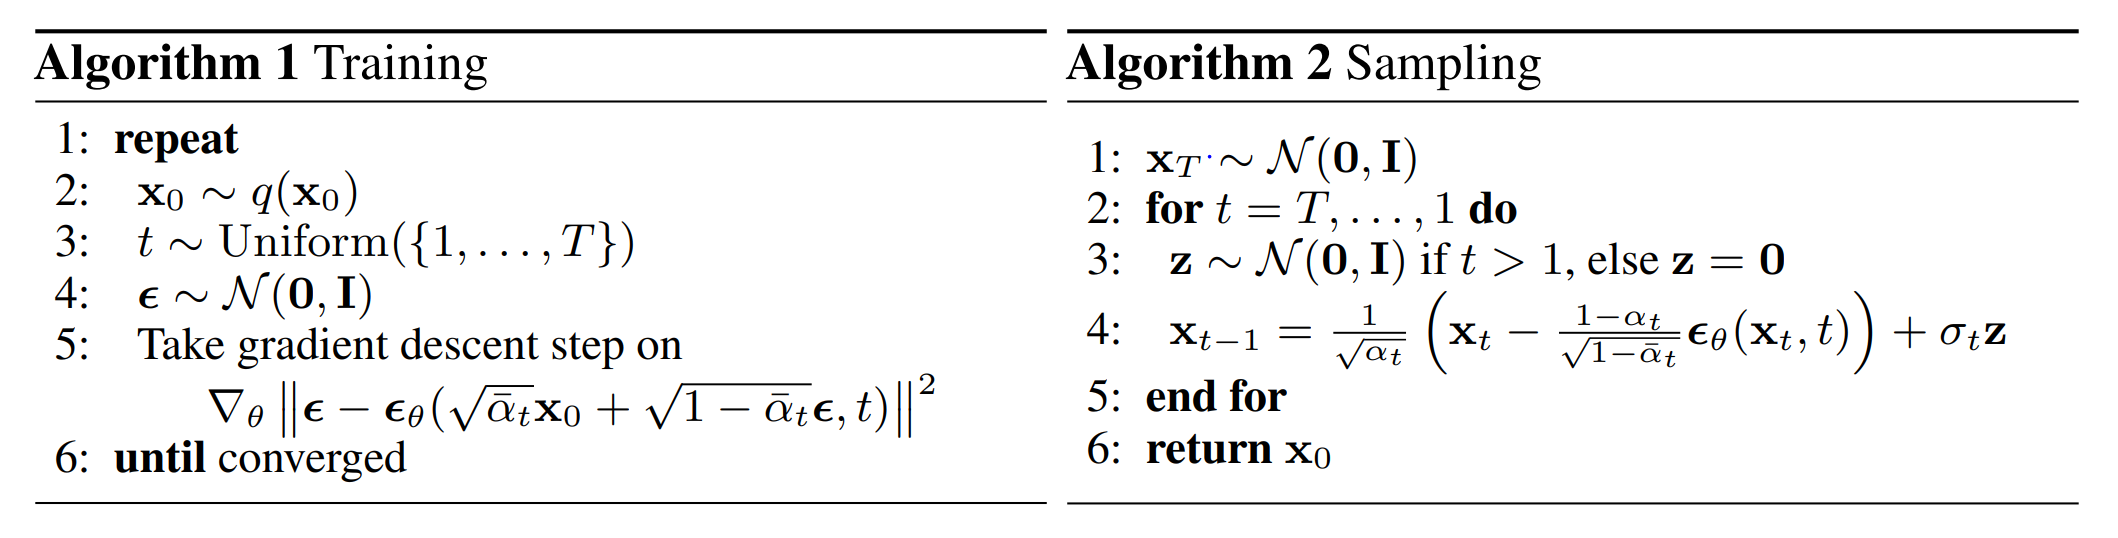

### 1.4.1 Noise scheduling
First of all, we need a variance scheduler for controlling the forward process. For the function in the cell below, define a linear variance scheduler $ \{\beta_t \in (0.0001, 0.04)\}^T_{t=1} $.

In [ ]:
def linear_beta_schedule(timesteps):
    """
    Create a linear beta schedule.

    Args:
        timesteps (int): The number of time steps.

    Returns:
        torch.Tensor: A tensor of beta values.
    """
    betas = torch.linspace(1e-4, 4e-2, timesteps)
    return betas

### 1.4.2 Foward & Backward Processes

For training and sampling by our diffusion model, you should complete the methods of `Diffusion` class regarding descriptions for each method.

In [ ]:
class Diffusion:
  """
  Class for diffusion process.
  Attributes:
    time_steps (int): The number of time steps.
  """
  def __init__(self, time_steps, image_channels=1, image_size=28):
    self.time_steps = time_steps
    self.image_channels = image_channels
    self.image_size = image_size

    self.betas = linear_beta_schedule(time_steps)
    self.alphas = 1. - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, dim=0)

    self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
    self.sqrt_one_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)

    self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
    self.sqrt_betas = torch.sqrt(self.betas)

    self.betas_div_sqrt_one_minus_alphas_bar = self.betas / self.sqrt_one_minus_alphas_bar


  def _move_constants_to_device(self, device):
      """Helper to move all constant tensors to the specified device."""
      self.betas = self.betas.to(device)
      self.alphas = self.alphas.to(device)
      self.alphas_bar = self.alphas_bar.to(device)
      self.sqrt_alphas_bar = self.sqrt_alphas_bar.to(device)
      self.sqrt_one_minus_alphas_bar = self.sqrt_one_minus_alphas_bar.to(device)
      self.sqrt_recip_alphas = self.sqrt_recip_alphas.to(device)
      self.sqrt_betas = self.sqrt_betas.to(device)
      self.betas_div_sqrt_one_minus_alphas_bar = self.betas_div_sqrt_one_minus_alphas_bar.to(device)
      
  def add_noise(self, x_0, t):
    """
    Add noise to the images.

    Args:
      x_0 (torch.Tensor): the batch of images.
      t (torch.Tensor): 1-D tensor indicating the time step of forward process.

    Returns:
      noisy_images (torch.Tensor): the batch of noisy images for time step t.
      noise (torch.Tensor): the noise added to images (\epsilon in Algorithm 1).
    """
    if self.sqrt_alphas_bar.device != x_0.device:
        self._move_constants_to_device(x_0.device)

    noise = torch.randn_like(x_0)
    sqrt_alphas_bar_t = gather(self.sqrt_alphas_bar, t)
    sqrt_one_minus_alphas_bar_t = gather(self.sqrt_one_minus_alphas_bar, t)

    noised_images = sqrt_alphas_bar_t * x_0 + sqrt_one_minus_alphas_bar_t * noise

    return noised_images, noise

  def train_loss(self, model, x_0, t):
    """
    Computes the MSE loss for training the conditional denoiser model.

    Args:
      model: the denoising U-Net model.
      x_0 (torch.Tensor): the batch of images.
      t (torch.Tensor): 1-D tensor indicating the time step of forward process.
      label (torch.Tensor): 1-D tensor indicating labels.
    Returns:
      loss (torch.Tensor): the MSE loss for training the denoising model.
    """
    x_t, true_noise = self.add_noise(x_0, t)
    predicted_noise = model(x_t, t)
    loss = F.mse_loss(predicted_noise, true_noise)

    return loss

  def denoise(self, x_t, pred_noise, t):
    """
    Sample the x_{t-1} from x_t in backward process.

    Args:
      x_t (torch.Tensor): the batch of noisy images for time step t.
      pred_noise (torch.Tensor): the predicted noise by denoising model.
      t (torch.Tensor): 1-D tensor indicating time step values.

    Returns:
      x_{t-1} (torch.Tensor): the sampled noisy images for time step (t-1).
    """
    if self.sqrt_recip_alphas.device != x_t.device:
        self._move_constants_to_device(x_t.device)

    sqrt_recip_alphas_t = gather(self.sqrt_recip_alphas, t)
    betas_div_sqrt_one_minus_alphas_bar_t = gather(self.betas_div_sqrt_one_minus_alphas_bar, t)
    sqrt_betas_t = gather(self.sqrt_betas, t)

    mean_pred = sqrt_recip_alphas_t * (x_t - betas_div_sqrt_one_minus_alphas_bar_t * pred_noise)
    
    noise = torch.randn_like(x_t)
    nonzero_mask = (t != 0).float().reshape(-1, 1, 1, 1)
    x_prev = mean_pred + nonzero_mask * sqrt_betas_t * noise

    return x_prev

  def sample(self, n, model, device):
    """
    Complete the sampling algorithm and generate images.
    create a random noise and denoise it from time step T to time step 0 by using self.denoise method.

    Args:
      n (int): Number of generated images.
      model (torch.nn.Module): The UNet network for denoising.
      device (torch.device): Device to perform computations on.

    Returns:
      generated_images (List): the list of generated grayscale images.
    """
    model.to(device)
    model.eval()

    if self.betas.device != device:
        self._move_constants_to_device(device)

    x_t = torch.randn(n, self.image_channels, self.image_size, self.image_size, device=device)

    with torch.no_grad():
      for i in tqdm(reversed(range(self.time_steps)), desc="Sampling", total=self.time_steps):
        current_t_int = i
        t_tensor = torch.full((n,), current_t_int, device=device, dtype=torch.long)
        
        pred_noise = model(x_t, t_tensor)

        x_t = self.denoise(x_t, pred_noise, t_tensor)

    generated_tensor = (x_t + 1.0) / 2.0
    generated_tensor = generated_tensor.clamp(0.0, 1.0)

    generated_images_pil = []
    for i in range(n):
        img_tensor_chw = generated_tensor[i]
        img_tensor_hwc = img_tensor_chw.permute(1, 2, 0).cpu().numpy()
        
        if img_tensor_hwc.shape[-1] == 1:
            img_tensor_hwc = img_tensor_hwc.squeeze(-1)
        
        img_numpy_uint8 = (img_tensor_hwc * 255).astype(np.uint8)
        pil_image = Image.fromarray(img_numpy_uint8)
        generated_images_pil.append(pil_image)
        
    return generated_images_pil

In [20]:
# Instantiate an object
time_steps = 100
diffusion = Diffusion(time_steps)
diffusion._move_constants_to_device(device)

## 1.5. Training

At last, in this part we train the model and use it for generating MNIST images.

### 1.5.1 Train the model

Complete the training loop and train the `unet` for using in diffusion process.

In [16]:
# Instantiate the model
unet = UnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4]
)
unet = unet.to(device)

In [ ]:
epochs = 20
lr = 1e-4

optimizer = torch.optim.AdamW(unet.parameters(), lr=lr)

print(f"Starting training for {epochs} epochs...")

for epoch in range(epochs):
    unet.train()
    epoch_loss = 0.0
    num_batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for step, (batch_images, _) in enumerate(pbar):
        optimizer.zero_grad()

        batch_images = batch_images.to(device)

        t = torch.randint(0, diffusion.time_steps, (batch_images.shape[0],), device=device).long()

        loss = diffusion.train_loss(unet, batch_images, t)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_epoch_loss:.4f}")

print("Training finished.")

Starting training for 20 epochs...


Epoch 1/20: 100%|██████████| 468/468 [01:25<00:00,  5.46it/s, loss=0.0603]


Epoch 1/20 - Average Loss: 0.1004


Epoch 2/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0651]


Epoch 2/20 - Average Loss: 0.0595


Epoch 3/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0520]


Epoch 3/20 - Average Loss: 0.0541


Epoch 4/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0464]


Epoch 4/20 - Average Loss: 0.0512


Epoch 5/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0474]


Epoch 5/20 - Average Loss: 0.0493


Epoch 6/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0495]


Epoch 6/20 - Average Loss: 0.0488


Epoch 7/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0521]


Epoch 7/20 - Average Loss: 0.0477


Epoch 8/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0473]


Epoch 8/20 - Average Loss: 0.0471


Epoch 9/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0434]


Epoch 9/20 - Average Loss: 0.0466


Epoch 10/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0456]


Epoch 10/20 - Average Loss: 0.0461


Epoch 11/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0455]


Epoch 11/20 - Average Loss: 0.0458


Epoch 12/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0434]


Epoch 12/20 - Average Loss: 0.0455


Epoch 13/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0401]


Epoch 13/20 - Average Loss: 0.0453


Epoch 14/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0479]


Epoch 14/20 - Average Loss: 0.0453


Epoch 15/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0451]


Epoch 15/20 - Average Loss: 0.0447


Epoch 16/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0464]


Epoch 16/20 - Average Loss: 0.0444


Epoch 17/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0456]


Epoch 17/20 - Average Loss: 0.0444


Epoch 18/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0405]


Epoch 18/20 - Average Loss: 0.0443


Epoch 19/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0434]


Epoch 19/20 - Average Loss: 0.0442


Epoch 20/20: 100%|██████████| 468/468 [01:24<00:00,  5.53it/s, loss=0.0442]

Epoch 20/20 - Average Loss: 0.0440
Training finished.


In [19]:
# Save the trained model

torch.save(unet.state_dict(), './unconditional_unet.pth')

### 1.5.2 Visualize generated images

Sample 100 images from your model and visualize them.

Starting to generate 100 images...


Sampling: 100%|██████████| 100/100 [00:05<00:00, 19.63it/s]


100 images generated successfully.


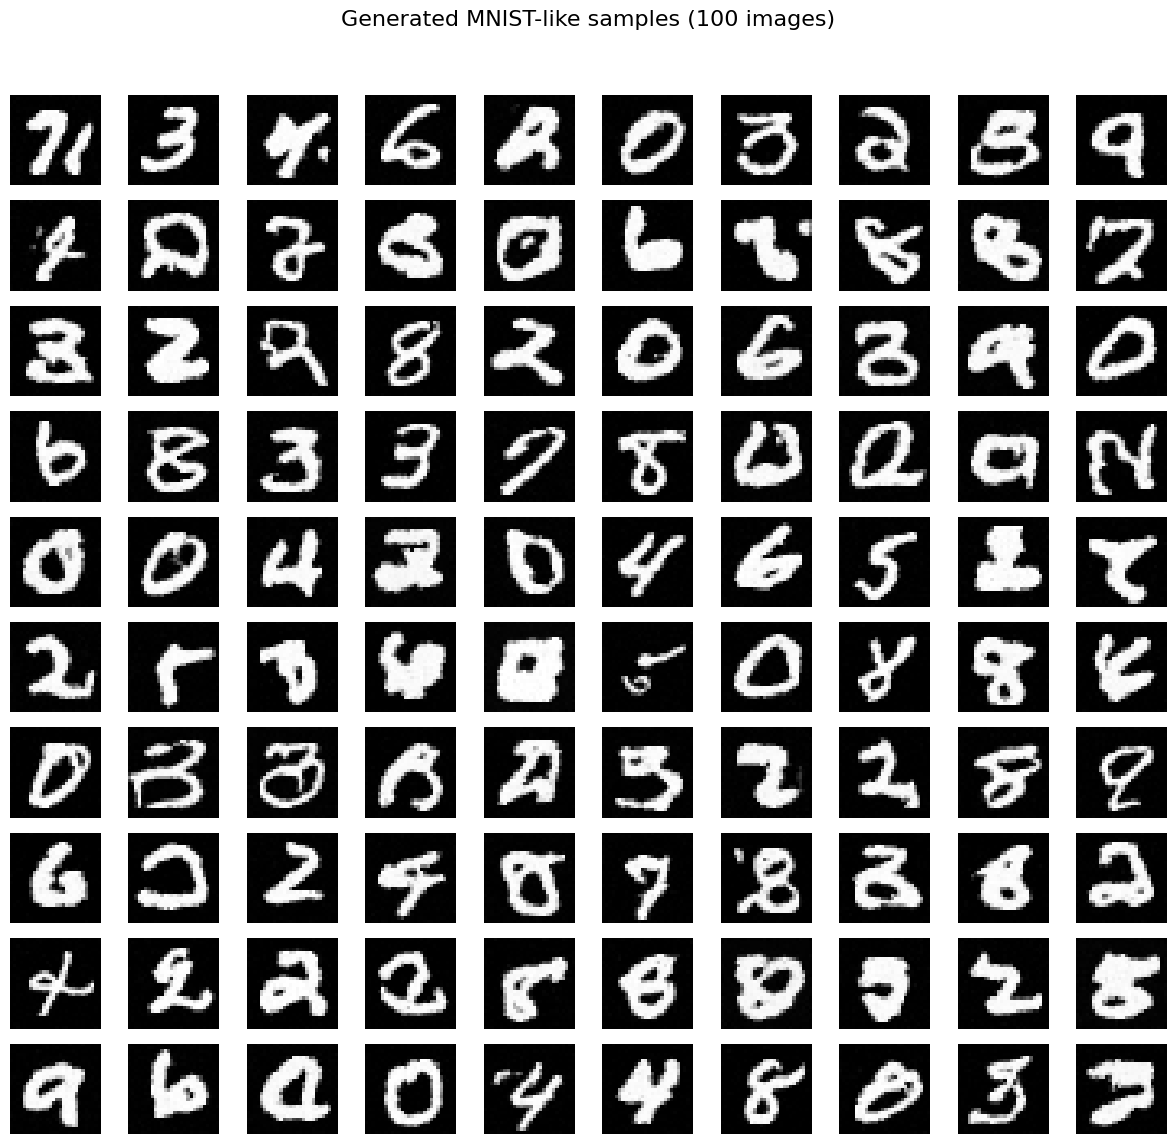

In [21]:
print("Starting to generate 100 images...")

num_images_to_generate = 100
unet.eval()

try:
    generated_images_pil = diffusion.sample(
        n=num_images_to_generate,
        model=unet,
        device=device
    )
    print(f"{len(generated_images_pil)} images generated successfully.")

    grid_rows = 10
    grid_cols = 10

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))
    axes = axes.flatten()

    for i, pil_image in enumerate(generated_images_pil):
        if i < len(axes):
            axes[i].imshow(pil_image, cmap='gray')
            axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Generated MNIST-like samples ({num_images_to_generate} images)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except AttributeError as e:
    print(f"AttributeError: {e}. Make sure 'diffusion.sample' method is correctly defined and accessible.")
    print("Also ensure 'unet' and 'diffusion' objects are properly initialized.")
except Exception as e:
    print(f"An error occurred during image generation or visualization: {e}")

# 2. Conditional DDPM

For the second part of the notebook, we aim to develop the conditional diffusion model on the MNIST dataset. The main reference for this part is [classifier-free diffusion guidance paper.](https://arxiv.org/abs/2207.12598). Please note that by using the guidlines of the notebooks, you can complete this part and there is no need to read the paper carefully.

# Introduction

As you know, one way for developing conditional diffusion models is classifier guidance method in which an auxilary classifier is used. Classifier guidance mixes a diffusion model's score estimate with the input gradient of the log probability of a classifier. However, classifier guidance complicates the diffusion model training pipeline because it requires training an extra classifier, and this classifier must be trained on noisy data so it is generally not possible to plug in a pre-trained classifier.

In this part,  we aim to develop a conditional diffusion model without the need to use a classifier. For this purpose, we need to modify the architecture of U-Net model in the previous part to enable it for getting the label of images as inputs.

**Note**: For this part, You can use your codes from the previous part. Actually, by appling slight adjustments to previous codes, you can complete this part.

## 2.1 Conditional U-Net Architecture

As the new inputs for the conditional U-Net model, we need **two new inputs**:

* Input for class labels

* 0-1 Masks for determining unconditional / conditional model. (if 0, model doesn't use class labels for predicting noise, if 1, model use class labels for predicting noise.

The second input will be useful for training and sampling algorithms.

**Hint**: For modules of U-Net not mentioned here, you can use the implementations from the previous part.

### 2.1.1 time step and class embedding class
We define the `TimestepClassEmbedSequential` to support the time embedding as the extra input for the layers of model.

In [21]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, t_emb, c_emb, mask):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepClassEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
        return x


### 2.1.2 Conditional Residual Block


First, we need to change the implementation of residual block. This modules gets **class labels embeddings** and **condition flag masks** as inputs. For implementation, you can use a *feed-forward layer for label embeddings, and apply the mask on the output of this layer*. Then, you can add the output to the time embedding and image embedding at the **residual connection**.

In [ ]:
# Residual block
class Conditional_Residual_block(TimestepBlock):
    """
    Conditional Residual block for Conditional U-Net architecture.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        time_channels (int): Size of the time embedding.
        class_channels (int): Size of the class embedding.
        dropout (float, optional): Dropout probability.
        num_groups (int): Number of groups to split the input into for normalization. Default is 32.
    """
    def __init__(self, in_channels, out_channels, time_channels, class_channels, dropout, num_groups=32):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.time_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.class_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_channels, out_channels)
        )
        
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.act2 = nn.SiLU()
        self.dropout_layer = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x, t_emb, c_emb, mask):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
            c (torch.Tensor): Class embedding tensor.
            mask (torch.Tensor): contional mask tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        h_skip = x

        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv1(x) 

        projected_time_emb = self.time_emb_proj(t_emb) 

        projected_class_emb = self.class_emb_proj(c_emb) 
        
        masked_projected_class_emb = projected_class_emb * mask.unsqueeze(-1).float()

        combined_conditioning_emb = projected_time_emb + masked_projected_class_emb
        
        x = x + combined_conditioning_emb.unsqueeze(-1).unsqueeze(-1)

        x = self.norm2(x)
        x = self.act2(x)
        x = self.dropout_layer(x)
        x = self.conv2(x) 
        
        h_skip_processed = self.skip_connection(h_skip)

        return x + h_skip_processed

### 2.1.3 Final Architecture

In this step, we implement the conditional U-Net model. You can use the same architecture used for the unconditional generation. However, you should use the contional residual connection to enable the model for the conditional generation.

Notes:
* Same as the time embedding, you need to transform the class labels to embedding vectors. For this purpose, you can use `nn.Embedding` module.

In [ ]:
class ConditionalUnetModel(nn.Module):
    """
    U-Net model for image generation.

    Args:
        in_channels (int): Number of input channels.
        model_channels (int): Number of channels in the model.
        out_channels (int): Number of output channels.
        num_res_blocks (int): Number of residual blocks at each level in the model.
        attention_resolutions (list): List of resolutions at which to apply attention.
        dropout (float): Dropout probability.
        channel_mult (list): List of channel multipliers for each stage (should be multiplied to model_channels).
        conv_resample (bool): Flag indicating whether to use convolution for up/down sampling blocks.
        num_heads (int): Number of attention heads.
        class_num (int): Number of classes.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    def __init__(self,
                 in_channels=1,
                 model_channels=64,
                 out_channels=1,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0.1,
                 channel_mult=(1,2,2,2),
                 conv_resample=True,
                 num_heads=4,
                 class_num=10,       
                 num_groups=32,
                 image_size=28       
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num
        self.num_groups = num_groups
        self.image_size = image_size

        time_emb_dim = model_channels * 4
        self.time_mlp = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        class_emb_dim = model_channels
        self.class_emb = nn.Embedding(class_num, class_emb_dim)

        self.init_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        self.down_blocks = nn.ModuleList()
        self.downsamplers = nn.ModuleList()

        current_resolution = image_size
        ch_at_level_start = model_channels

        for i, mult in enumerate(channel_mult):
            out_ch_for_resblocks = model_channels * mult
            
            level_specific_blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                level_specific_blocks.append(Conditional_Residual_block(
                    in_channels=ch_at_level_start,
                    out_channels=out_ch_for_resblocks,
                    time_channels=time_emb_dim,
                    class_channels=class_emb_dim,
                    dropout=dropout,
                    num_groups=num_groups
                ))
                ch_at_level_start = out_ch_for_resblocks

                if current_resolution in self.attention_resolutions:
                    level_specific_blocks.append(AttentionBlock(
                        channels=out_ch_for_resblocks,
                        num_heads=num_heads,
                        num_groups=num_groups
                    ))
            self.down_blocks.append(TimestepClassEmbedSequential(*level_specific_blocks))
            
            is_last_down_level = (i == len(channel_mult) - 1)
            if not is_last_down_level:
                self.downsamplers.append(Downsample(
                    channels=out_ch_for_resblocks, 
                    use_conv=conv_resample
                ))
                current_resolution //= 2
            else:
                self.downsamplers.append(nn.Identity())


        middle_ch = ch_at_level_start
        middle_block_modules = [
            Conditional_Residual_block(middle_ch, middle_ch, time_emb_dim, class_emb_dim, dropout, num_groups)
        ]
        if current_resolution in self.attention_resolutions:
            middle_block_modules.append(AttentionBlock(middle_ch, num_heads, num_groups))
        middle_block_modules.append(
            Conditional_Residual_block(middle_ch, middle_ch, time_emb_dim, class_emb_dim, dropout, num_groups)
        )
        self.middle_block = TimestepClassEmbedSequential(*middle_block_modules)
        
        self.up_blocks = nn.ModuleList()
        
        ch_flowing_up = middle_ch

        for i, mult in reversed(list(enumerate(channel_mult))):
            out_ch_for_resblocks = model_channels * mult 
            
            level_specific_modules = nn.ModuleList()
            
            skip_ch_from_down = model_channels * mult

            for k in range(num_res_blocks + 1):
                if k == 0:
                    res_input_ch = ch_flowing_up + skip_ch_from_down
                else:
                    res_input_ch = out_ch_for_resblocks
                
                level_specific_modules.append(Conditional_Residual_block(
                    in_channels=res_input_ch,
                    out_channels=out_ch_for_resblocks,
                    time_channels=time_emb_dim,
                    class_channels=class_emb_dim,
                    dropout=dropout,
                    num_groups=num_groups
                ))

                if current_resolution in self.attention_resolutions:
                    level_specific_modules.append(AttentionBlock(
                        channels=out_ch_for_resblocks,
                        num_heads=num_heads,
                        num_groups=num_groups
                    ))
            
            ch_flowing_up = out_ch_for_resblocks

            is_output_level = (i == 0)
            if not is_output_level:
                level_specific_modules.append(Upsample(
                    channels=out_ch_for_resblocks,
                    use_conv=conv_resample
                ))
                current_resolution *= 2
            
            self.up_blocks.append(TimestepClassEmbedSequential(*level_specific_modules))

        final_in_ch = model_channels * channel_mult[0]
        self.final_norm = nn.GroupNorm(num_groups, final_in_ch) 
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(final_in_ch, self.out_channels, kernel_size=3, padding=1)

    def forward(self, x, timesteps, c, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param c: a 1-D batch of classes.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """
        t_sin_emb = timestep_embedding(timesteps, self.model_channels, max_period=10000)
        t_emb = self.time_mlp(t_sin_emb)

        c_emb = self.class_emb(c)

        h = self.init_conv(x)
        hs = [h]

        for i in range(len(self.down_blocks)):
            res_attn_module_seq = self.down_blocks[i]
            downsampler_op = self.downsamplers[i]
            
            h = res_attn_module_seq(h, t_emb, c_emb, mask)
            hs.append(h)
            h = downsampler_op(h)        
            
        h = self.middle_block(h, t_emb, c_emb, mask)

        for level_module_seq in self.up_blocks:
            skip_h = hs.pop()
            h = torch.cat([h, skip_h], dim=1)
            h = level_module_seq(h, t_emb, c_emb, mask)
            
        h = self.final_norm(h)
        h = self.final_act(h)
        h = self.final_conv(h)

        return h

## 2.2 Classifier-free guidance diffusion process

As it is stated in the reference paper, for training the model, we need to train it for both unconditional and conditional inputs. Therefore, we need to consider both inputs through training. The training algorithm is:

Training algorithm:

Require $p_{uncond}$: Probability of unconditional training

1. **repeat**
2. $ (x, c) \sim q(x, c)$
3. mask = 0 with the probability $p_{uncond}$
3. $t \sim Uniform(\{1, 2, ..., T\})$
4. $\epsilon \sim N(0, I)$
5. Take gradient descent on

&emsp;&emsp; $\nabla_{\theta} ||\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t, c, mask)||$
6. **until** converged

For sampling, as the similar as the classifier guidance method, we need to use the predcited noise of conditional model to generate the image for a certain class. The sampling algorithm is:

Sampling algorithm

define $w$: guidance strength
1. $ x_T \sim N(0, I) $
2. for $ t = T, \ldots, 1 $ do
3. &emsp;&emsp;$ z \sim N(0, I) $ if $ t > 1 $, else $ z = 0 $
4. &emsp;&emsp;$\epsilon_{pred} = (1+w)\epsilon_{\theta}(x_t, t, c, I) - w\epsilon_{\theta}(x_t, t, c, 0)$
5. &emsp;&emsp;$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{pred} \right) + \sigma_t z $
5. end for
6. return $ x_0 $

In [ ]:
class ConditionalDiffusion:
  """
  Class for conditional diffusion process.
  Attributes:
    time_steps (int): The number of time steps.
    w (int): Guidance strength parameter. default is 2.
    p_uncond (float): Probability of unconditional training. default is 0.2.
  """
  def __init__(self, time_steps, w=2.0, p_uncond=0.2, image_channels=1, image_size=28): 
    self.time_steps = time_steps
    self.w = w
    self.p_uncond = p_uncond
    self.image_channels = image_channels
    self.image_size = image_size
      
    self.betas = linear_beta_schedule(time_steps)
    self.alphas = 1. - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
    self.sqrt_one_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)
    self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
    self.betas_div_sqrt_one_minus_alphas_bar = self.betas / self.sqrt_one_minus_alphas_bar
    self.sqrt_betas = torch.sqrt(self.betas)

  def _move_constants_to_device(self, device):
      """Helper to move all constant tensors to the specified device."""
      self.betas = self.betas.to(device)
      self.alphas = self.alphas.to(device)
      self.alphas_bar = self.alphas_bar.to(device)
      self.sqrt_alphas_bar = self.sqrt_alphas_bar.to(device)
      self.sqrt_one_minus_alphas_bar = self.sqrt_one_minus_alphas_bar.to(device)
      self.sqrt_recip_alphas = self.sqrt_recip_alphas.to(device)
      self.betas_div_sqrt_one_minus_alphas_bar = self.betas_div_sqrt_one_minus_alphas_bar.to(device)
      self.sqrt_betas = self.sqrt_betas.to(device)

  def _move_constants_to_device(self, device):
      self.betas = self.betas.to(device)
      self.alphas = self.alphas.to(device)
      self.alphas_bar = self.alphas_bar.to(device)
      self.sqrt_alphas_bar = self.sqrt_alphas_bar.to(device)
      self.sqrt_one_minus_alphas_bar = self.sqrt_one_minus_alphas_bar.to(device)
      self.sqrt_recip_alphas = self.sqrt_recip_alphas.to(device)
      self.sqrt_betas = self.sqrt_betas.to(device)
      self.betas_div_sqrt_one_minus_alphas_bar = self.betas_div_sqrt_one_minus_alphas_bar.to(device)

  def add_noise(self, x_0, t):
    """
    Add noise to the images.

    Args:
      x_0 (torch.Tensor): the batch of images.
      t (torch.Tensor): 1-D tensor indicating the time step of forward process.

    Returns:
      noisy_images (torch.Tensor): the batch of noisy images for time step t.
      noise (torch.Tensor): the noise added to images (\epsilon in Algorithm 1).
    """
    if self.sqrt_alphas_bar.device != x_0.device: 
        self._move_constants_to_device(x_0.device)

    noise = torch.randn_like(x_0)
    sqrt_alphas_bar_t = gather(self.sqrt_alphas_bar, t)
    sqrt_one_minus_alphas_bar_t = gather(self.sqrt_one_minus_alphas_bar, t)

    noised_images = sqrt_alphas_bar_t * x_0 + sqrt_one_minus_alphas_bar_t * noise
    
    return noised_images, noise
    
  def train_loss(self, model, x_0, t, label):
    """
    Computes the MSE loss for training the conditional denoiser model.

    Args:
      model: the denoising U-Net model.
      x_0 (torch.Tensor): the batch of images.
      t (torch.Tensor): 1-D tensor indicating the time step of forward process.
      label (torch.Tensor): 1-D tensor indicating labels.
    Returns:
      loss (torch.Tensor): the MSE loss for training the denoising model.
    """
    x_t, true_noise = self.add_noise(x_0, t)

    batch_size = x_0.shape[0]
    probs = torch.full((batch_size,), self.p_uncond, device=x_0.device)
    mask = (torch.rand(batch_size, device=x_0.device) > self.p_uncond).long()
                                                                           
    predicted_noise = model(x_t, t, label, mask)

    loss = F.mse_loss(predicted_noise, true_noise)
    
    return loss

  def denoise(self, x_t, pred_noise, t):
    """
    Sample the x_{t-1} from x_t in backward process.

    Args:
      x_t (torch.Tensor): the batch of noisy images for time step t.
      pred_noise (torch.Tensor): the predicted noise (\epsilon_{pred} in sampling algorithm)
      t (torch.Tensor): 1-D tensor indicating time step values.

    Returns:
      x_{t-1} (torch.Tensor): the sampled noisy images for time step (t-1).
    """
    if self.sqrt_recip_alphas.device != x_t.device: # Just for check (remove it later)
        self._move_constants_to_device(x_t.device)

    sqrt_recip_alphas_t = gather(self.sqrt_recip_alphas, t)
    betas_t = gather(self.betas, t)
    sqrt_one_minus_alphas_bar_t = gather(self.sqrt_one_minus_alphas_bar, t)
    
    coeff_eps = gather(self.betas_div_sqrt_one_minus_alphas_bar, t)
    mean_pred = sqrt_recip_alphas_t * (x_t - coeff_eps * pred_noise)
    noise_for_variance = torch.randn_like(x_t)
    nonzero_mask = (t != 0).float().reshape(-1, 1, 1, 1)
    sqrt_betas_t = gather(self.sqrt_betas, t)
    
    x_prev = mean_pred + nonzero_mask * sqrt_betas_t * noise_for_variance
    return x_prev

  def sample(self, n, model, label, device):
    """
    Complete the sampling algorithm and generate images.
    create a random noise and denoise it from time step T to time step 0 by using self.denoise method.

    Args:
      n (int): Number of generated images.
      model (torch.nn.Module): The UNet network for denoising.
      label (torch.Tensor): 1-D tensor indicating labels.
      device (torch.device): Device to perform computations on.

    Returns:
      generated_images (List): the list of generated grayscale images.
    """
    model.eval()
    model.to(device)

    if self.betas.device != device:
        self._move_constants_to_device(device)

    if label.numel() == 1 and n > 1:
        labels_batch = label.repeat(n).to(device)
    elif label.numel() == n:
        labels_batch = label.to(device)
    else:
        raise ValueError(f"Label tensor must have 1 or n ({n}) elements, but got {label.numel()}")

    x_t = torch.randn(n, self.image_channels, self.image_size, self.image_size, device=device)

    mask_cond = torch.ones(n, device=device).long() 
    mask_uncond = torch.zeros(n, device=device).long()

    with torch.no_grad():
      for i in tqdm(reversed(range(self.time_steps)), desc="Sampling", total=self.time_steps):
        current_t_int = i
        t_tensor = torch.full((n,), current_t_int, device=device, dtype=torch.long)
        pred_noise_cond = model(x_t, t_tensor, labels_batch, mask_cond)
        pred_noise_uncond = model(x_t, t_tensor, labels_batch, mask_uncond)
        epsilon_pred = (1 + self.w) * pred_noise_cond - self.w * pred_noise_uncond
        x_t = self.denoise(x_t, epsilon_pred, t_tensor)
        
    generated_tensor = (x_t + 1.0) / 2.0 
    generated_tensor = generated_tensor.clamp(0.0, 1.0)

    generated_images_pil = []
    for i in range(n):
        img_tensor_chw = generated_tensor[i]
        img_tensor_hwc = img_tensor_chw.permute(1, 2, 0).cpu().numpy()
        
        if img_tensor_hwc.shape[-1] == 1:
            img_tensor_hwc = img_tensor_hwc.squeeze(-1)
        
        img_numpy_uint8 = (img_tensor_hwc * 255).astype(np.uint8)
        pil_image = Image.fromarray(img_numpy_uint8)
        generated_images_pil.append(pil_image)
        
    return generated_images_pil

In [25]:
# Get an instance
time_steps = 100
conditional_diffusion = ConditionalDiffusion(time_steps)

## 2.3 Training

### 2.3.1 Train the model

Complete the training loop and train the `conditional_unet` for using in diffusion process.

In [55]:
conditional_unet = ConditionalUnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4],
    class_num=10
)
conditional_unet = conditional_unet.to(device)

In [ ]:
epochs = 20
lr = 1e-4

optimizer = torch.optim.AdamW(conditional_unet.parameters(), lr=lr)

print(f"Starting training for {epochs} epochs with Conditional U-Net...")
conditional_unet.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for step, (batch_images, batch_labels) in enumerate(pbar):
        optimizer.zero_grad()

        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        t = torch.randint(0, conditional_diffusion.time_steps, (batch_images.shape[0],), device=device).long()

        loss = conditional_diffusion.train_loss(conditional_unet, batch_images, t, batch_labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_epoch_loss:.4f}")

print("Training finished.")

Starting training for 20 epochs with Conditional U-Net...


Epoch 1/20: 100%|██████████| 468/468 [01:27<00:00,  5.34it/s, loss=0.0692]


Epoch 1/20 - Average Loss: 0.1222


Epoch 2/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0501]


Epoch 2/20 - Average Loss: 0.0654


Epoch 3/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0590]


Epoch 3/20 - Average Loss: 0.0576


Epoch 4/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0551]


Epoch 4/20 - Average Loss: 0.0542


Epoch 5/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0462]


Epoch 5/20 - Average Loss: 0.0524


Epoch 6/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0479]


Epoch 6/20 - Average Loss: 0.0508


Epoch 7/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0492]


Epoch 7/20 - Average Loss: 0.0493


Epoch 8/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0461]


Epoch 8/20 - Average Loss: 0.0487


Epoch 9/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0440]


Epoch 9/20 - Average Loss: 0.0483


Epoch 10/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0461]


Epoch 10/20 - Average Loss: 0.0474


Epoch 11/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0450]


Epoch 11/20 - Average Loss: 0.0470


Epoch 12/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0452]


Epoch 12/20 - Average Loss: 0.0465


Epoch 13/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0488]


Epoch 13/20 - Average Loss: 0.0462


Epoch 14/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0458]


Epoch 14/20 - Average Loss: 0.0461


Epoch 15/20: 100%|██████████| 468/468 [01:27<00:00,  5.36it/s, loss=0.0465]


Epoch 15/20 - Average Loss: 0.0454


Epoch 16/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0460]


Epoch 16/20 - Average Loss: 0.0455


Epoch 17/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0473]


Epoch 17/20 - Average Loss: 0.0452


Epoch 18/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0463]


Epoch 18/20 - Average Loss: 0.0451


Epoch 19/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0490]


Epoch 19/20 - Average Loss: 0.0450


Epoch 20/20: 100%|██████████| 468/468 [01:27<00:00,  5.37it/s, loss=0.0462]

Epoch 20/20 - Average Loss: 0.0445
Training finished.


In [58]:
# Save the trained model
torch.save(conditional_unet.state_dict(), './conditional_unet.pth')

### 2.3.2 Visualize generated images

For the visualization part, you should generate images of 0-9 classes 10 times and visualiza them like the output of below cell.

Generating 10 images for class 0...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 46.71it/s]


Successfully generated 10 images for class 0.
Generating 10 images for class 1...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 48.95it/s]


Successfully generated 10 images for class 1.
Generating 10 images for class 2...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 49.31it/s]


Successfully generated 10 images for class 2.
Generating 10 images for class 3...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 49.38it/s]


Successfully generated 10 images for class 3.
Generating 10 images for class 4...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 48.90it/s]


Successfully generated 10 images for class 4.
Generating 10 images for class 5...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 47.64it/s]


Successfully generated 10 images for class 5.
Generating 10 images for class 6...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 48.61it/s]


Successfully generated 10 images for class 6.
Generating 10 images for class 7...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 48.98it/s]


Successfully generated 10 images for class 7.
Generating 10 images for class 8...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 49.04it/s]


Successfully generated 10 images for class 8.
Generating 10 images for class 9...


Sampling: 100%|██████████| 100/100 [00:02<00:00, 48.17it/s]


Successfully generated 10 images for class 9.

100 images generated successfully in total.


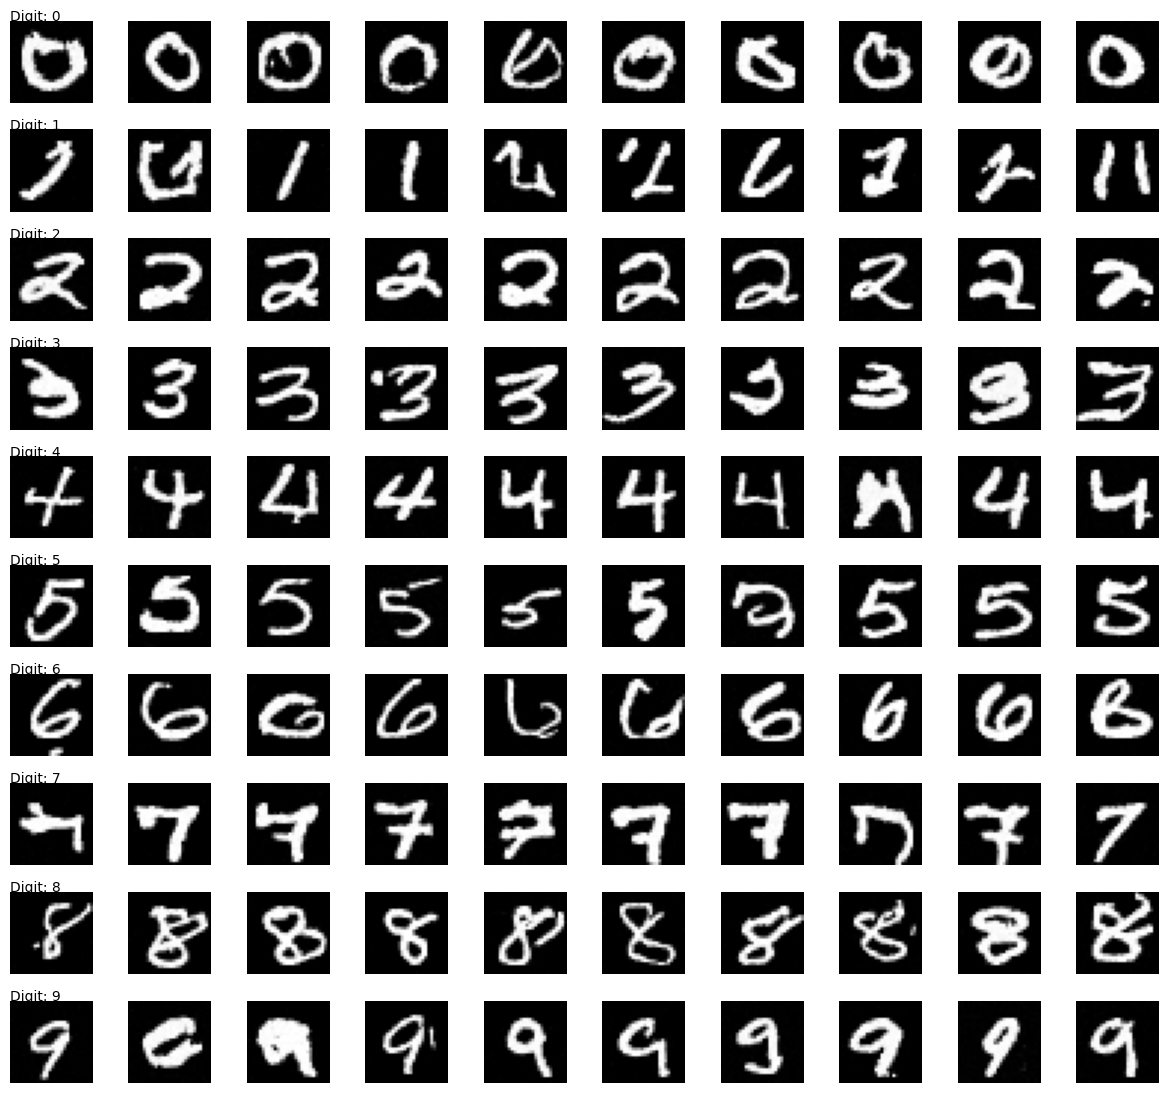

In [ ]:
num_classes = 10
images_per_class = 10
total_images_to_generate = num_classes * images_per_class

conditional_unet.eval()
conditional_unet.to(device)

all_generated_images_pil = []
all_labels_for_images = []

for class_label_int in range(num_classes):
    print(f"Generating {images_per_class} images for class {class_label_int}...")
    
    current_class_labels_tensor = torch.tensor([class_label_int] * images_per_class, device=device, dtype=torch.long)
    
    try:
        generated_images_for_class_pil = conditional_diffusion.sample(
            n=images_per_class,
            model=conditional_unet,
            label=current_class_labels_tensor,
            device=device
        )
        all_generated_images_pil.extend(generated_images_for_class_pil)
        all_labels_for_images.extend([class_label_int] * images_per_class)
        print(f"Successfully generated {len(generated_images_for_class_pil)} images for class {class_label_int}.")
        
    except AttributeError as e:
        print(f"AttributeError during sampling for class {class_label_int}: {e}.")
        break 

if len(all_generated_images_pil) == total_images_to_generate:
    print(f"\n{len(all_generated_images_pil)} images generated successfully in total.")

    grid_rows = num_classes
    grid_cols = images_per_class

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))
    
    for i, pil_image in enumerate(all_generated_images_pil):
        row = i // grid_cols
        col = i % grid_cols
        
        ax = axes[row, col]
        ax.imshow(pil_image, cmap='gray')
        ax.axis('off')
        if col == 0:
            ax.set_title(f"Digit: {all_labels_for_images[i]}", fontsize=10, loc='left', y=0.9)

    for i in range(len(all_generated_images_pil), grid_rows * grid_cols):
        row = i // grid_cols
        col = i % grid_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"\nImage generation was incomplete. Generated {len(all_generated_images_pil)} out of {total_images_to_generate} images.")

# 3. Evaluation (extra 10 points)

For this part, you should measure the quality of generated images by (unconditional or conditional model) in comparison to the real images. You are free to choose any appropriate metric for this purpose. Also, you are free to implement this part from scratch or use an additional library. In the cell below, write a brief description about your chosen metric and how it works.

`Your answer`:
The Fréchet Inception Distance (FID) is a widely adopted metric for evaluating the quality of images generated by models like GANs and Diffusion Models. It quantifies the similarity between the distribution of features from generated images and the distribution of features from real images. These features are typically extracted using a pre-trained InceptionV3 network (though other feature extractors can be used).


Feature Extraction: A set of real images and a set of generated images are fed through a pre-trained InceptionV3 model. The activations from a specific layer (commonly the global average pooling layer, which outputs 2048 features) are collected for every image in both sets.

Modeling Feature Distributions: The collection of feature vectors for the real images and for the generated images are each modeled as a multivariate Gaussian distribution.

Calculating Statistics: From these feature vectors, the mean and covariance matrix are computed for both the real (r) and generated (g) sets.

Fréchet Distance Calculation: The FID score is the Fréchet distance (also known as Wasserstein-2 distance) between these two Gaussian distributions:

A lower FID score indicates that the distribution of generated images is closer to the distribution of real images, implying better quality (fidelity) and diversity.

In [26]:
!pip install pytorch-fid

In [27]:
conditional_unet = ConditionalUnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4],
    class_num=10
)

conditional_unet.load_state_dict(torch.load('./conditional_unet.pth', map_location=device))

<All keys matched successfully>

In [ ]:
def preprocess_for_inception(images):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    preprocessed = torch.stack([transform(img) for img in images])
    return preprocessed

def save_images_to_dir(images, directory):
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        img.save(os.path.join(directory, f'image_{i}.png'))

def compute_fid(real_images, generated_images, device, batch_size=50):
    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as gen_dir:
        save_images_to_dir(generated_images, gen_dir)
        real_images_pil = []
        for img in real_images:
            img = (img + 1.0) / 2.0
            img = img.clamp(0.0, 1.0)
            img = (img.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
            pil_img = Image.fromarray(img)
            real_images_pil.append(pil_img)
        save_images_to_dir(real_images_pil, real_dir)
        
        fid_value = fid_score.calculate_fid_given_paths(
            [real_dir, gen_dir],
            batch_size=batch_size,
            device=device,
            dims=2048
        )
        return fid_value

def evaluate_model(dataloader, conditional_diffusion, conditional_unet, device, num_samples=1000, class_label=0):
    real_images = []
    total_images = 0
    for images, _ in dataloader:
        real_images.append(images.to(device))
        total_images += images.shape[0]
        if total_images >= num_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:num_samples]
    
    label = torch.tensor([class_label], device=device)
    generated_images = conditional_diffusion.sample(
        n=num_samples,
        model=conditional_unet,
        label=label,
        device=device
    )
    
    fid_score_value = compute_fid(real_images, generated_images, device)
    print(f"FID Score for class {class_label}: {fid_score_value:.2f}")
    return fid_score_value

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conditional_unet.eval()
conditional_unet.to(device)

total_fid_score = 0.0
for label in range(10):
    total_fid_score += evaluate_model(
        dataloader=dataloader,
        conditional_diffusion=conditional_diffusion,
        conditional_unet=conditional_unet,
        device=device,
        num_samples=25,
        class_label=label
    )

print(f"FID Score for classes: {total_fid_score / 10}")

Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


FID Score for class 0: 157.08


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.75it/s]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


FID Score for class 1: 142.32


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


FID Score for class 2: 140.89


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


FID Score for class 3: 165.10


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


FID Score for class 4: 155.46


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.80it/s]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


FID Score for class 5: 137.59


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


FID Score for class 6: 136.49


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


FID Score for class 7: 150.34


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


FID Score for class 8: 143.41


Sampling: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


FID Score for class 9: 142.20
FID Score for classes: 147.08806305303995
